# Simple example of integrating the Rubidium wavefunction

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from numerov.matrix_elements import radial_matrix_element_from_w_z
from numerov.rydberg import RydbergState
from numerov.units import ureg

logging.basicConfig(level=logging.INFO, format="%(levelname)s %(filename)s: %(message)s")
logging.getLogger("numerov").setLevel(logging.WARNING)

In [2]:
n = 120
dn, dl, dj, dm = (3, 1, 0, 0)

qn1 = (n, n - 1, n - 0.5, n - 0.5)
qn2 = (qn1[0] + dn, qn1[1] + dl, qn1[2] + dj, qn1[3] + dm)
qns = [qn1, qn2]

dz = 1e-2

In [3]:
numerov_results = []
atoms = []
for qn in qns:
    atom = RydbergState("Rb", n=qn[0], l=qn[1], j=qn[2])
    atom.create_grid(dz=dz)
    atom.integrate()
    numerov_results.append(
        {
            "x": atom.grid.xlist,
            "z": atom.grid.zlist,
            "u": atom.ulist,
            "w": atom.wlist,
            "z_cutoff": atom.z_cutoff,
        }
    )
    atoms.append(atom)

In [4]:
import arc

arc_atom = arc.Rubidium87()

arc_default_results = []

for qn in qns:
    n, l, j, m = qn
    energy = arc_atom.getEnergy(n, l, j) / 27.211
    arc_x, arc_u = arc_atom.radialWavefunction(
        int(l),
        0.5,
        j,
        energy,
        dz,
        2.0 * n * (n + 15.0),
        step=dz,
    )
    arg_rmin = np.argwhere(arc_u != 0).flatten()[0]

    arc_default_results.append(
        {
            "x": np.array(arc_x),
            "z": np.sqrt(arc_x),
            "u": np.array(arc_u),
            "w": np.array(arc_u) / np.power(arc_x, 1 / 4),
            "z_cutoff": np.sqrt(arc_x[arg_rmin]),
        }
    )

In [5]:
import arc

arc_atom = arc.Rubidium87()

arc_fixed_results = []

for qn in qns:
    n, l, j, m = qn
    energy = arc_atom.getEnergy(n, l, j) / 27.211_386_245_988  # Note the fixed Hartree energy
    arc_x, arc_u = arc_atom.radialWavefunction(
        int(l),
        0.5,
        j,
        energy,
        dz,
        2.0 * n * (n + 15.0),
        step=dz,
    )
    arg_rmin = np.argwhere(arc_u != 0).flatten()[0]

    arc_fixed_results.append(
        {
            "x": np.array(arc_x),
            "z": np.sqrt(arc_x),
            "u": np.array(arc_u),
            "w": np.array(arc_u) / np.power(arc_x, 1 / 4),
            "z_cutoff": np.sqrt(arc_x[arg_rmin]),
        }
    )

In [6]:
results = {
    "numerov": numerov_results,
    "arc default": arc_default_results,
    "arc fixed": arc_fixed_results,
}

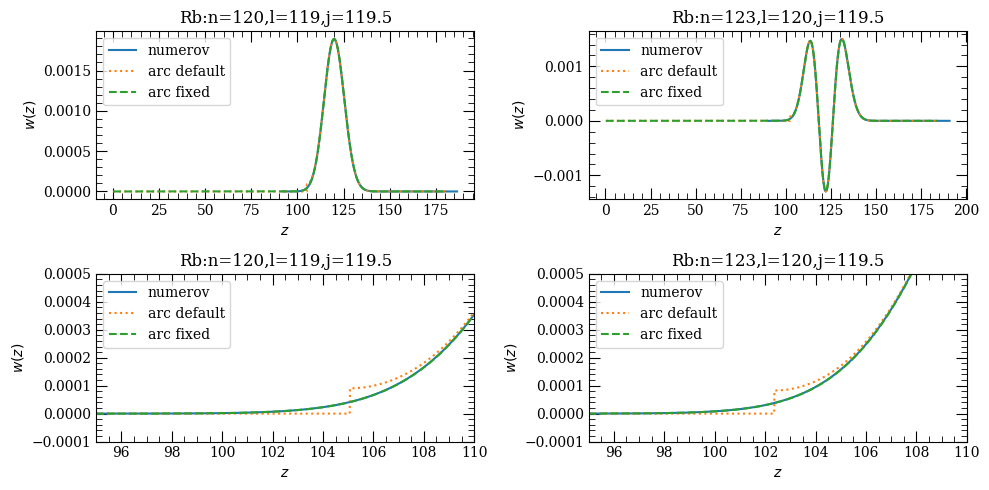

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

for j, row in enumerate(axs):
    for i, ax in enumerate(row):
        for k, r_list in results.items():
            r = r_list[i]
            ls = {"numerov": "-", "arc default": ":", "arc fixed": "--"}[k]
            ax.plot(r["z"], r["w"], ls=ls, label=f"{k}")

        ax.set_xlabel(r"$z$")
        ax.set_ylabel(r"$w(z)$")
        ax.legend()
        ax.set_title(f"{atoms[i].species}:n={atoms[i].n},l={atoms[i].l},j={atoms[i].j}")

        if j == 1:
            ax.set_xlim(95, 110)
            ax.set_ylim(-1e-4, 5e-4)

fig.tight_layout()
plt.show()

In [8]:
# the small difference of the wavefunctions explains the difference in the radial matrix element of circular states
# (see also the benchmark_circular_matrixelements.ipynb notebook)
to_mum = ureg.Quantity(1, "bohr_radius").to("micrometer").magnitude

for key in results.keys():
    key1 = key2 = key
    i1, i2 = 0, 1
    overlap = radial_matrix_element_from_w_z(
        results[key1][i1]["z"], results[key1][i1]["w"], results[key2][i2]["z"], results[key2][i2]["w"], r_power=1
    )
    print(rf"matrix element <{key1}_{i1}|{key2}_{i2}> = {overlap * to_mum} $\mu m$")

matrix element <numerov_0|numerov_1> = 0.006611390310047011 $\mu m$
matrix element <arc default_0|arc default_1> = 0.007832348346155267 $\mu m$
matrix element <arc fixed_0|arc fixed_1> = 0.006614522469875942 $\mu m$
